In [ ]:
# # -----------------------------
# #  Install necessary packages (based on Python>3.8)
 # -----------------------------
!pip install botorch
!pip install numpy
!pip install gpytorch
!pip install scipy
!pip install -U scikit-learn
import numpy as np

In [ ]:
# -----------------------------
#  Load all libraries required.
# -----------------------------
import torch
import gpytorch

from botorch.models import SingleTaskMultiFidelityGP
from botorch.acquisition.analytic import ExpectedImprovement

from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
# from botorch import fit_gpytorch_model OLD!!!!
from botorch import fit_gpytorch_mll
from sklearn.ensemble import RandomForestRegressor


from scipy.stats import norm
import numpy as np
import pandas as pd
import pickle
import h5py # for .jld2 files
import os
import time

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
import seaborn as sns
sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine()
# plt.rcParams.update({'font.size': 16})
# plt.rcParams['figure.dpi'] = 1200 # 600-1200 for paper quality
# save_figures = True

discrete_fidelities = [1/3, 2/3] # set of discrete fidelities (in ascending order) to select from this cannot be changed.
ablation_study_flag = False # make features have no information for a baseline. to gauge feature importance
from google.colab import files
uploaded = files.upload()
import pandas as pd
file = file = pd.read_excel('solvents_t1.xlsx')
feature_names = list(file.columns[:-1])


Saving solvents_t1.xlsx to solvents_t1.xlsx


<Figure size 640x480 with 0 Axes>

In [ ]:
# feature matrix in torch tensor
X = torch.from_numpy(np.array(file.iloc[:,1:8]))
if ablation_study_flag:
    # suffle columns
    for j in range(X.size()[1]):
        shuffled_row_ids - torch.randper(X.size()[0])
        X[:, j] = X[shuffled_row_ids, j]
# simulation data
y = [torch.from_numpy(np.array(file["lnk_MLR"])),
     torch.from_numpy(np.array(file["lnk_QM"][:]))]

print("=====Top solvent is====")
p1 = file[file["lnk_QM"] == file["lnk_QM"].max()]["Solvent"].iloc[0]
p2 = file[file["lnk_QM"] == file["lnk_QM"].max()]["lnk_QM"].iloc[0]
print("The best sovlent found is {} and its lnk_QM value is {}".format(p1,p2))
print("=======================")

# associated simulation costs
cost = [np.transpose(np.array(file["MLR_total_eleapsed_time"][:])),       # [min]
        np.transpose(np.array(file["QM_total_eleapsed_time"][:]))]        # [min]

=====Top solvent is====
The best sovlent found is solvent326 and its lnk_QM value is -5.9


In [ ]:
# total number of solvents (SOLs) in data set
nb_SOLs = X.shape[0]
# The first 9 solvents are our baseline that will be used for the initialisation of BO
file.head(9)

nb_solvent = 9           # The number of solvents in the initial set
nb_runs = 50             # Total budget, i.e., the number of iteration
num_features = len(X[0]) # Number of feature

init_sol_ids = np.array(range(0,nb_solvent))

# Print the solvent features (X)
for i, f in enumerate(feature_names):
    if (i>0) & (i<num_features+1):
        print("{}: {}".format(i, f))

for j in range(X.size()[1]):
    X[:, j] = (X[:, j] - torch.min(X[:, j]).item()) / (torch.max(X[:, j]).item() - torch.min(X[:, j]).item())

1: n_square
2: A
3: B
4: Gamma
5: Epsilon
6: Aromaticity
7: Halogenicity


In [ ]:
# normalization worked
assert np.allclose(torch.min(X, 0).values, torch.zeros(num_features))
assert np.allclose(torch.max(X, 0).values, torch.ones(num_features))

# cost
print("total high-fidelity cost   :", sum(cost[1]).item(), "[min]")
print("total low-fidelity cost    :", sum(cost[0]).item(), "[min]")
print("average high-fidelity cost :", np.mean(cost[1]), "[min]")
print("average low-fidelity cost  :", np.mean(cost[0]), "[min]")
print("average cost ratio         :", np.mean(cost[1] / cost[0]))

# data shape
print("\nraw data - \n\tX:", X.shape)
for f in range(2):
    print("\tfidelity:", f)
    print("\t\ty:", y[f].shape)
    print("\t\tcost: ", cost[f].shape)

# normalization check
print("\nEnsure features are normalized - ")
print("max:\n", torch.max(X, 0).values)
print("min:\n", torch.min(X, 0).values)
print("width:\n",torch.max(X, 0).values - torch.min(X, 0).values)
print("mean:\n", torch.mean(X, 0))
print("std:\n", torch.std(X, 0))

total high-fidelity cost   : 167285 [min]
total low-fidelity cost    : 748.3000000000003 [min]
average high-fidelity cost : 499.35820895522386 [min]
average low-fidelity cost  : 2.233731343283582 [min]
average cost ratio         : 313.2549525806738

raw data - 
	X: torch.Size([335, 7])
	fidelity: 0
		y: torch.Size([335])
		cost:  (335,)
	fidelity: 1
		y: torch.Size([335])
		cost:  (335,)

Ensure features are normalized - 
max:
 tensor([1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
min:
 tensor([0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
width:
 tensor([1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
mean:
 tensor([0.4042, 0.1540, 0.3370, 0.3222, 0.0658, 0.0590, 0.0092],
       dtype=torch.float64)
std:
 tensor([0.0887, 0.2108, 0.1510, 0.1425, 0.0803, 0.1967, 0.0777],
       dtype=torch.float64)


In [ ]:
# return list of fidelity id's (0's and 1's) from the acquired set.
def get_f_ids(acquired_set):
    if acquired_set.dim() == 0:
        return acquired_set.round().to(dtype=int)
    else:
        f_ids = [a[0].round().to(dtype=int) for a in acquired_set]
        return torch.tensor(f_ids)

# get the list of high-fidelity y_max's from iter-to-iter
# returns an array.
# element i is best y-max high fidelity seen up to iteration i.
def get_y_maxes_hf_acquired(acquired_set):
    nb_iters = len(acquired_set)
    y_maxes = np.zeros(nb_iters)
    # we want the maximum y value (only high-fidelity) up to a given iteration
    y_max = 0.0 # update this each iteration.
    for i, (f_val, cof_id) in enumerate(acquired_set):
        f_id = get_f_ids(torch.tensor(f_val))
        assert f_id in [0, 1]
        y_acq_this_iter = y[f_id][int(cof_id)]
        # i is iteration index
        if f_id == 1 and y_acq_this_iter > y_max:
            y_max = y_acq_this_iter # over-write max
        y_maxes[i] = y_max
    return y_maxes


In [ ]:


# find accumulated cost, given acquired set.
# returns an array.
# element i is cost accumulated till iteration i
def accumulated_cost(acquired_set):
    nb_iters = len(acquired_set)
    accumulated_cost = np.zeros(nb_iters)
    for i, (f_val, cof_id) in enumerate(acquired_set):
        cof_id = int(cof_id.item())
        f_id = f_val.round().to(dtype=int).item()
        if i == 0:
            accumulated_cost[i] = cost[f_id][cof_id]
        else:
            accumulated_cost[i] = accumulated_cost[i-1] + cost[f_id][cof_id]
    return accumulated_cost


In [ ]:
# calcualte the fraction of sims up to that point that are a given fidelity
# entry i is fraction of sims up to that point that are fidelity fidelity.
def calc_fidelity_fraction(acquired_set, fidelity):
    assert fidelity in [1/3, 2/3]
    nb_iters = len(acquired_set)
    fid_frac = np.zeros(nb_iters)
    for i in range(nb_iters):
        fid_frac[i] = sum(acquired_set[:, 0][:i+1] == fidelity) / (i+1)
    return fid_frac

def initialize_acquired_set(initializing_SOLs, discrete_fidelities):
    return torch.tensor([[f_id, sol_id] for sol_id in initializing_SOLs for f_id in discrete_fidelities])


In [ ]:
# construct feature matrix of acquired points.
# the last entry is the fidelity parameter.
def build_X_train(acquired_set):
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    f_ids = torch.tensor([a[0] for a in acquired_set])
    assert f_ids[0] in [1/3, 2/3]
    return torch.cat((X[cof_ids, :], f_ids.unsqueeze(dim=-1)), dim=1)

# construct output vector for acquired points
def build_y_train(acquired_set):
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set] # this is where the "experiment" is conducted
    return torch.tensor([y[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids)]).unsqueeze(-1)

In [ ]:
# construct vector to track cost of acquired points
# entry i is cost of acquired Solvent i
def build_cost(acquired_set):
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return torch.tensor([cost[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids)]).unsqueeze(-1)

# construct vector to track cost of acquired points
# entry i is cost of acquired COF i within a given fidelity_id
def build_cost_fidelity(acquired_set, fidelity_id):
    assert fidelity_id in [0, 1]
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return torch.tensor([cost[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids) if f_id == fidelity_id]).unsqueeze(-1)

In [ ]:
# return trained surrogate model
def train_surrogate_model(X_train, y_train):
    model = SingleTaskMultiFidelityGP(
        X_train,
        y_train,
        linear_truncated=True, #set to true so that its linear truncated kernel
        outcome_transform=Standardize(m=1), # m is the output dimension
        # data_fidelity=X_train.shape[1] - 1 old
        data_fidelities=[X_train.shape[1]-1]
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    # fit_gpytorch_model(mll) # old
    return model

# return mean, standard deviation of posterior acc to surrogate model
def mu_sigma(model, X, fidelity):
    assert fidelity in [1/3, 2/3]
    nb_SOLs_here = X.size()[0]
    f = torch.tensor((), dtype=torch.float64).new_ones((nb_SOLs_here, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity
    f_posterior = model.posterior(X_f)
    return f_posterior.mean.squeeze().detach().numpy(), np.sqrt(f_posterior.variance.squeeze().detach().numpy())

In [ ]:
# ratio of mean cost of sims of high fidelity to those of fidelity-fidelity, within acquired set so far.
def estimate_cost_ratio(acquired_set, fidelity):
    assert fidelity in [1/3, 2/3]
    f_id = get_f_ids(torch.tensor(fidelity))
    avg_cost_f  = torch.mean(build_cost_fidelity(acquired_set, f_id).float())
    avg_cost_hf = torch.mean(build_cost_fidelity(acquired_set, 1).float())
    cr = avg_cost_hf / avg_cost_f
    return cr.item()

In [ ]:
# get the current best y-value of desired_fidelity in the acquired set
def get_y_max(acquired_set, fidelity):
    assert fidelity in [0, 1]
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return np.max([y[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids) if f_id == fidelity])

In [ ]:
###
#  efficient multi-fidelity correlation function
#  corr(y at given fidelity, y at high-fidelity)
#  (see notes)
#  This is the second term in the AugEI acquisition function
###
def mfbo_correlation_function(model, X, fidelity):
    assert fidelity in [1/3, 2/3]
    # given fidelity
    f   = torch.tensor((), dtype=torch.float64).new_ones((nb_SOLs, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity

    #  high-fidelity
    hf   = torch.tensor((), dtype=torch.float64).new_ones((nb_SOLs, 1)) * discrete_fidelities[-1]
    X_hf = torch.cat((X, hf), dim=1) # last col is associated fidelity

    # combine into a single tensor
    X_all_fid = torch.cat((X_f, X_hf), dim=0)

    # get variance for each fidelity
    var_f = torch.flatten(model.posterior(X_f).variance)
    var_hf = torch.flatten(model.posterior(X_hf).variance) # variance

    # posterior covariance
    cov = torch.diag(model(X_all_fid).covariance_matrix[:X_f.size()[0], X_f.size()[0]:])

    corr = cov / (torch.sqrt(var_f) * torch.sqrt(var_hf))
    return corr

In [ ]:
###
#  expected imrovement function, only uses hf
#  we have a GP for the high fidelity and for the low fidelity
#  we only consult the high fidelity GP
###
def EI_hf(model, X, acquired_set):
    '''
    This function returns a vector of length X
    The acquired set is the observed set
    The function assigns an EI value to each solvent in X
    '''
    hf_mu, hf_sigma = mu_sigma(model, X, discrete_fidelities[-1]) # hf_mu and hf_sigma are vectors of length 335 (each solvent that was not in the initial set)
    y_max = get_y_max(acquired_set, 1)

    z = (hf_mu - y_max) / hf_sigma
    explore_term = hf_sigma * norm.pdf(z)
    exploit_term = (hf_mu - y_max) * norm.cdf(z)
    ei = explore_term + exploit_term
    return np.maximum(ei, np.zeros(X.size()[0]))

###
#  acquisition function combining the three terms (EI, Corr, CostRatio) as in the Gantzler paper
###
def acquisition_scores(model, X, fidelity, acquired_set):
    assert fidelity in [1/3, 2/3]
    # expected improvement for high-fidelity
    ei = EI_hf(model, X, acquired_set)

    # augmenting functions
    corr_f1_f0 = mfbo_correlation_function(model, X, fidelity)

    cr = estimate_cost_ratio(acquired_set, fidelity)

    scores = torch.from_numpy(ei) * corr_f1_f0 * cr
    return scores.detach().numpy()

In [ ]:
# return True if (f_id, cof_id) in acquired set and False otherwise
def in_acquired_set(f_id, cof_id, acquired_set):
    assert f_id in [0, 1]
    fidelity = discrete_fidelities[f_id]
    for this_fidelity, this_cof_id in acquired_set:
        if this_cof_id == cof_id and this_fidelity == fidelity:
            return True
    return False

In [ ]:
def run_Bayesian_optimization(nb_iterations, initializing_SOLs, verbose=False, stop_after_top_acquired=True):
    assert nb_iterations > len(initializing_SOLs)

    ###
    #  initialize acquired set
    ###
    acquired_set = initialize_acquired_set(initializing_SOLs, discrete_fidelities)

    # the initial acquired set is a 18x2 vector with fidelities (0.3 and 0.6) and solvent ID (0 to 8, one for each fidelity level)

    for i in range(len(initializing_SOLs), nb_iterations):
        #print("BO iteration: ", i)
        ###
        #  construct training data (perform experiments)
        ###
        X_train = build_X_train(acquired_set)

        # the initial training set is an 18x8 matrix with columns 1-7: features 1: n_square 2: A 3: B 4: Gamma 5: Epsilon 6: Aromaticity 7: Halogenicity and column 8 as fidelity (0.3, 0.6) (again, each row doubles and has either 0.3 or 0.6 in the end)

        y_train = build_y_train(acquired_set)

        # y_train is the non-normalized versions with solvatochromic logk and qm logk in alternating rows (meaning 2 rows for each solvent), again the initial set is an 18x1 matrix

        if verbose:
            print("Initialization - \n")
            print("\tSOL IDs acquired    = ", [acq_[1].item() for acq_ in acquired_set])
            print("\tfidelities acquired = ", [acq_[0].item() for acq_ in acquired_set])
            print("\tcosts acquired      = ", build_cost(acquired_set), " [min]")

            print("\n\tTraining data:\n")
            print("\t\t X train shape = ", X_train.shape)
            print("\t\t y train shape = ", y_train.shape)
            print("\t\t training feature vector = \n", X_train)

        ###
        #  train Model (maximize mll)
        ###



        model = train_surrogate_model(X_train, y_train)

        ###
        #  acquire new (SOL, fidelity) not yet acquired.
        ###
        # entry (fid_id, sol_id) is the acquisition value for fidelity f_id and cof sol_id
        the_acquisition_scores = np.array([acquisition_scores(model, X, fidelity, acquired_set) for fidelity in discrete_fidelities])
        # in the first iteration, this function returns a vector of size 2x355 (first row low fidelity scores, second row high fidelity scores)
        # the acquisiiton scores include the high-fidelity EI x term2 x term3, whereas only term2 and term3 are dependend on the fidelity

        print(the_acquisition_scores)


        # overwrite acquired SOLs/fidelities with negative infinity to not choose these.
        for fidelity, sol_id in acquired_set:
            the_acquisition_scores[get_f_ids(fidelity), sol_id.to(dtype=int)] = - np.inf

        # in the first run, the first nine solvents are overwritten (as these were the training samples)
        # it looks like there is no difference between X and the acquired dataset, as the acquired dataset seems to be part of X

        # select SOL/fidelity with highest aquisition score.
        f_id, sol_id = np.unravel_index(np.argmax(the_acquisition_scores), np.shape(the_acquisition_scores))

        assert f_id in [0, 1]
        assert not in_acquired_set(f_id, sol_id, acquired_set)
        assert np.max(the_acquisition_scores) == the_acquisition_scores[f_id, sol_id]

        # update acquired_set
        acq = torch.tensor([[discrete_fidelities[f_id], sol_id]]) # dtype=int
        acquired_set = torch.cat((acquired_set, acq))
        # acquired set is updated and has now +1 rows. It has two columns, first one is solvent ID and second one is fidelity.
        # implicit here is that all solvents in the acquired set have had the highest acquisition score within the untested ones at one point.

        ###
        #  print useful info
        ###
        if verbose:
            print("\tacquired Solvent ", sol_id, " at fidelity, ", f_id)
            print("\t\ty = ", y[f_id][sol_id].item())
            print("\t\tcost = ", cost[f_id][sol_id])

        if stop_after_top_acquired:
            sol_id_with_max_selectivity = np.argmax(y[1])
            if sol_id_with_max_selectivity == sol_id and f_id == 1:
                print("found top Solvent! exiting.")

    return acquired_set

In [ ]:
# ---------------------------------------------
#  construct initial inputs
# ---------------------------------------------
nb_SOLs_initialization = nb_solvent    # at each fidelity, number of SOLs to initialize with
nb_iterations = nb_runs                # BO budget, includes initializing SOLs. This is actually max # iterations

if ablation_study_flag:
    print("ablation study: {}".format(ablation_study_flag))
     # the maximum possible number iterations = num_fidelities * nb_COFs
     # this would efectively constitute a low-fidelity exhaustive search
     # followed by a high-fidelity exhaustive search

    nb_iterations = 2 * nb_SOLs
    print("max. number of iterations: {}".format(nb_iterations))

In [ ]:
if not ablation_study_flag:

    # 50 iterations
    # init solvent IDs: [0 1 2 3 4 5 6 7 8]

    acquired_set = run_Bayesian_optimization(nb_iterations, init_sol_ids, verbose=False)

    ## post analysis
    #
    # unpack search results
    f_ids   = [acquired_set[i][0].item()      for i in range(len(acquired_set))]
    sol_ids = [int(acquired_set[i][1].item()) for i in range(len(acquired_set))]

    # which SOL has the largest high-fidelity reaction constant?
    sol_id_with_max_hi_fid_logk = np.argmax(y[1]).item()

    # iteration we found top SOL
    n_iter_top_sol_found = np.where([sol_ids[i] == sol_id_with_max_hi_fid_logk and f_ids[i] > 0.5 for i in range(len(sol_ids))])[0].item()
    print("iteration we acquire top SOLVENT = ", n_iter_top_sol_found)
    print("accumulated cost up to observation of top SOLVENT = ", accumulated_cost(acquired_set)[n_iter_top_sol_found], " [min]")


Streaming output truncated to the last 5000 lines.
  1.30714458e-013 1.94674939e-020 1.35582231e-043 4.92064425e-051
  2.89478986e-014 7.52309711e-021 2.79148425e-032 1.03755395e-033
  1.02029090e-010 3.12250545e-011 9.77398637e-012 3.63979321e-010
  3.52647546e-100 3.76451915e-021 1.14509670e-024 1.17853351e-011
  6.94029403e-018 1.91359701e-070 2.34159838e-032 4.74996343e-046
  2.80554216e-089 2.76421507e-016 5.18870278e-029 1.90419024e-018
  1.83214415e-025 1.23774053e-014 9.22113159e-056 3.13103205e-069
  2.58158839e-032 2.93083624e-017 2.89471856e-015 5.86585161e-040
  4.01808097e-026 3.92806008e-018 1.17256487e-012 7.34847049e-042
  0.00000000e+000 2.90134255e-013 5.47156716e-019 2.32760411e-022
  6.75892811e-014 4.40754236e-019 3.62594866e-011 3.82295610e-047
  1.07336663e-010 1.51444606e-011 5.29212730e-011 2.84664912e-037
  6.23374607e-015 5.21456006e-040 1.81647752e-010 1.24237939e-027
  1.94408223e-028 1.99687387e-036 3.05623325e-023 2.44303414e-026
  9.73298879e-016 5.80712

In [ ]:
# find SOLs that are simualted in with high- and low-fidelity.
hi_fid_sols = [sol_ids[i] for i in range(n_iter_top_sol_found) if f_ids[i] > 0.5]
lo_fid_sols = [sol_ids[i] for i in range(n_iter_top_sol_found) if f_ids[i] < 0.5]

# find SOLs simulated at both fidelities
ids_sols_hi_and_lo_fid = np.intersect1d(hi_fid_sols, lo_fid_sols)
ids_sols_hi_and_lo_fid

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

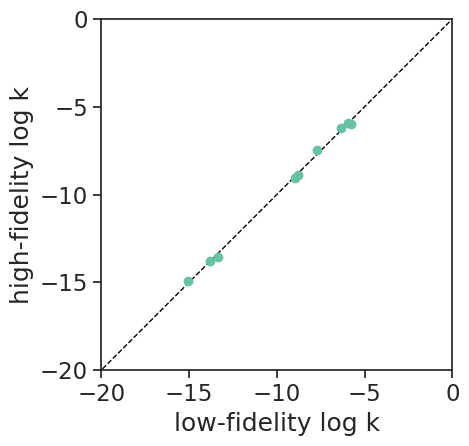

In [ ]:
# build logk array for plotting,
y_los = [y[0][c].item() for c in ids_sols_hi_and_lo_fid]
y_his = [y[1][c].item() for c in ids_sols_hi_and_lo_fid]

fig = plt.figure()
plt.plot([-100, 100], [-100, 100], linestyle="--", color="k", linewidth=1)
plt.scatter(y_los, y_his, zorder=10)
ax = plt.gca()
plt.xlim(-20, 0)
plt.ylim(-20, 0)
ax.set_aspect("equal", "box")
plt.xlabel("low-fidelity log k")
plt.ylabel("high-fidelity log k")
plt.tight_layout()
plt.show()

In [ ]:
# get SOL ids not in acquired set with high-fidelity sims. these are test SOLs for high-fidelity standpoint.
test_sol_ids = [sol_id for sol_id in range(nb_SOLs) if not (sol_id in hi_fid_sols)]
len(test_sol_ids)

326

In [ ]:
sol_id_with_max_hi_fid_logk in test_sol_ids # the SOL with the highest logk should be in here. cuz we didn't acquire it yet.

True

In [ ]:
id_in_test_sols_of_opt_sol = np.where([c == sol_id_with_max_hi_fid_logk for c in test_sol_ids])[0].item()
id_in_test_sols_of_opt_sol

325

In [ ]:
# train surrogate model for test data, on acquired set up till top COF was found.
X_train = build_X_train(acquired_set[:n_iter_top_sol_found])
y_train = build_y_train(acquired_set[:n_iter_top_sol_found])

X_test = X[test_sol_ids, :]

model = train_surrogate_model(X_train, y_train)

# get model predictions on test COFs, for high-fidelity.
y_pred, sigma = mu_sigma(model, X_test, discrete_fidelities[-1])

# plot true vs predicted
y_true = [y[1][c].item() for c in test_sol_ids]

r2 = r2_score(y_true, y_pred)
abserr = mean_absolute_error(y_true, y_pred)


In [ ]:
r2_score(y_pred,y_true)

-0.6230598971745949

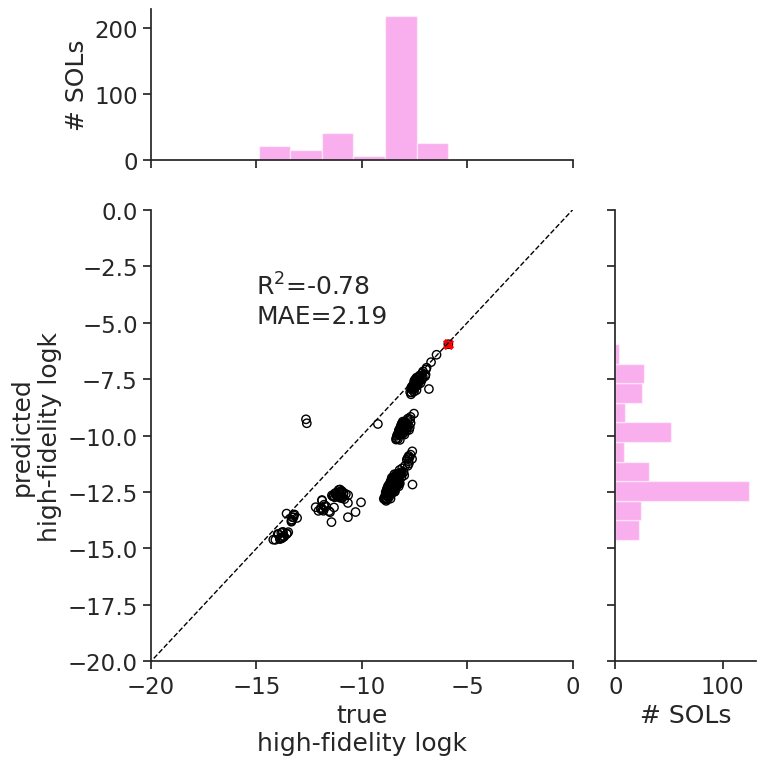

In [ ]:
###
#  parity plot
###
gridspec_kw={'width_ratios': [6, 2], 'height_ratios': [2, 6]} # set ratios
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw=gridspec_kw, figsize=(8, 8))
# fig = plt.figure()
ax[0, 1].axis("off")
ax[1, 0].plot([-100, 100], [-100, 100], linestyle="--", color="k", linewidth=1)
# ax = plt.gca()
ax[1, 0].set_xlim(-20, 0)
ax[1, 0].set_ylim(-20, 0)

#ax[1, 0].set_aspect("equal", "box")

ax[1, 0].text(-15, -5, "R$^2$=%.2f\nMAE=%.2f" % (r2, abserr))
ax[1, 0].scatter(y_true, y_pred, fc='none', ec="k")
ax[1, 0].set_xlabel("true\nhigh-fidelity logk")
ax[1, 0].set_ylabel("predicted\nhigh-fidelity logk")
# plot acquired COF
ax[1, 0].scatter(y_true[id_in_test_sols_of_opt_sol], y_pred[id_in_test_sols_of_opt_sol], marker="x", color="red")


###
#  histogram of logk
###
hist_color = sns.color_palette("husl", 8)[7]
ax[0, 0].hist(y_true, color=hist_color, alpha=0.5) #
ax[0, 0].sharex(ax[1, 0])
ax[0, 0].set_ylabel('# SOLs')
plt.setp(ax[0, 0].get_xticklabels(), visible=False) # remove yticklabels

hist_color = sns.color_palette("husl", 8)[7]
ax[1, 1].hist(y_pred, color=hist_color, alpha=0.5, orientation="horizontal") #
ax[1, 1].sharey(ax[1, 0])
ax[1, 1].set_xlabel('# SOLs')
plt.setp(ax[1, 1].get_yticklabels(), visible=False) # remove yticklabels

sns.despine()
plt.tight_layout()

plt.show()

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train[:, :7], y_train)
rf.score(X_test, y_true)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.6058339682709568

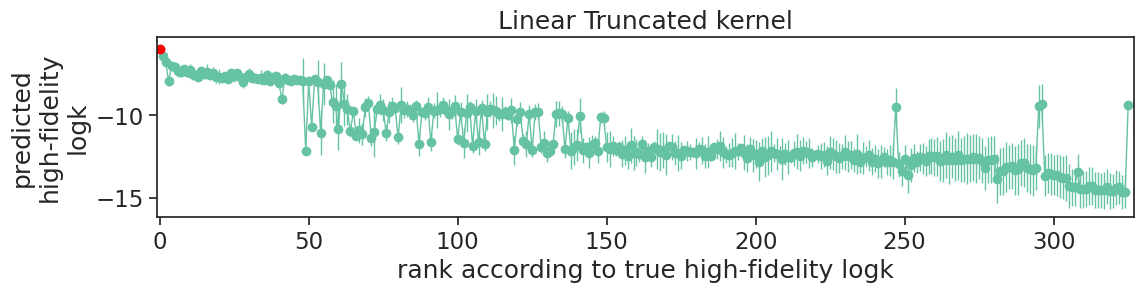

In [ ]:
ids_sorted = np.argsort(y_true)[::-1]

plt.figure(figsize=(12, 3))
plt.errorbar(range(len(y_true)), y_pred[ids_sorted], yerr=sigma, linewidth=1, marker="o")
plt.errorbar(0, y_pred[id_in_test_sols_of_opt_sol], yerr=sigma[id_in_test_sols_of_opt_sol], linewidth=1, marker="o", color="red")
plt.xlabel("rank according to true high-fidelity logk")
plt.ylabel("predicted\nhigh-fidelity\nlogk")
plt.xlim(-1, len(test_sol_ids) +1)
plt.tight_layout()
plt.title('Linear Truncated kernel')
plt.show()

In [ ]:
np.where([sol_id == sol_id_with_max_hi_fid_logk for sol_id in test_sol_ids])

(array([325]),)

# Trajectory plots


Streaming output truncated to the last 5000 lines.
  6.63554455e-12 2.96372715e-09 3.75526448e-04 5.65038108e-04
  4.24562285e-12 5.78526277e-12 3.79526418e-10 5.01221733e-13
  1.33426253e-13 5.89460971e-12 6.17322115e-07 6.88859336e-07
  1.25824439e-13 4.30996451e-04 1.67500476e-09 4.39819380e-04
  2.60615513e-13 7.97671564e-14 6.74472655e-14 2.55320520e-12
  1.05913139e-03 1.43701483e-11 6.85580886e-11 2.19597947e-13
  4.85287146e-11 5.88948590e-04 2.05305798e-09 6.66244115e-07
  7.25382103e-04 5.16885256e-13 3.70205308e-04 1.10547080e-10
  4.00654003e-11 2.43978835e-13 4.46989446e-04 5.16463735e-04
  3.68373685e-09 1.47753313e-13 5.87902036e-13 1.15997824e-07
  5.13193995e-11 1.55529931e-13 5.00847000e-14 6.32393452e-08
  2.14399018e-14 2.68765482e-14 3.60619448e-13 3.80421910e-10
  4.54256879e-14 1.10404028e-12 3.90772296e-14 1.61632410e-11
  7.63386365e-14 5.18923019e-15 1.90303246e-14 4.85990311e-08
  1.09469988e-12 7.78932991e-08 1.67380818e-13 1.44635952e-10
  7.80003399e-10 4.

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


Streaming output truncated to the last 5000 lines.
  5.60752634e-022 0.00000000e+000 3.66643552e-034 8.57079868e-028
  4.44549155e-226 4.59124005e-155 1.23239645e-112 5.88790199e-031
  1.15346898e-044 0.00000000e+000 4.01147286e-169 3.71379243e-068
  2.17850533e-062 1.69246126e-044 0.00000000e+000 1.31349682e-031
  3.93157931e-023 4.21241893e-028 4.68239582e-034 9.75055882e-019
  8.81440678e-014 0.00000000e+000 1.15279061e-309 4.05011875e-034
  1.26562348e-232 2.06382340e-023 3.63330167e-242 1.34098568e-054
  7.87772384e-016 3.12991052e-053 5.80630556e-033 2.37287160e-285
  0.00000000e+000 5.49999374e-071 7.37771928e-026 6.59110551e-018
  4.81633328e-147 1.16743640e-092 6.23528980e-098 5.95975997e-235
  0.00000000e+000 5.85966436e-163 1.94695366e-033 3.66951230e-111
  0.00000000e+000 1.26632088e-044 2.64188710e-287 4.69321814e-121
  3.57806223e-059 1.37707388e-313 3.97620096e-029 1.08947933e-093
  1.06342173e-024 2.98453623e-028 1.98483196e-023 1.08387785e-199
  4.85028006e-049 4.44422

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


Streaming output truncated to the last 5000 lines.
  5.22991519e-162 0.00000000e+000 9.58000072e-245 1.10178765e-234
  0.00000000e+000 8.34023035e-253 9.46437371e-212 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 3.08178618e-192
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  4.87607592e-176 2.04013222e-229 9.30844118e-201 9.13899838e-091
  1.36194871e-046 0.00000000e+000 0.00000000e+000 2.94960258e-146
  6.50204718e-318 1.28087087e-094 0.00000000e+000 7.12582555e-141
  1.10623478e-066 2.61850059e-247 0.00000000e+000 2.79025293e-204
  0.00000000e+000 0.00000000e+000 3.71645538e-131 5.02425458e-098
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 6.59768786e-186 1.41751167e-198
  4.32693902e-167 2.01680990e-190 5.81971851e-122 0.00000000e+000
  0.00000000e+000 5.91266

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Streaming output truncated to the last 5000 lines.
   1.10703756e+001  2.21677134e-007  5.49953817e+001  2.51768512e-005
   3.20341341e-007  1.06841493e+001  2.30768572e+001  4.78643878e+001
   1.47601347e-007  4.94219027e+001  5.10052251e+001  5.05715843e+001
   9.40006611e-012  4.74227223e-013  1.98752534e-012  9.47503913e-009
   5.22244140e+001  1.04980171e+001  5.35465425e+001  5.11701609e-010
   3.78318630e-014  2.88710221e+001  5.02106205e+001  4.74526939e+001
   5.08928879e+001  2.27013827e+001  4.87771384e+001  5.10339764e-008
   5.24302898e+001  2.37130642e-008  2.79049137e+001  4.90825339e+001
   4.95210855e+001  2.15670352e+001  5.10937321e-007  2.22887966e+001
   5.15032175e+001  2.07933409e+001  3.59346171e-005  4.89100447e+001
   4.11127698e+001  7.44612480e-006  2.02273957e+001  2.48794910e+001
   6.86664709e-006  1.07851687e+001  2.80374058e-013  3.45031635e-003
   3.30356661e-013  1.52715562e-003  4.57012956e-003  2.17851045e+001
   1.18685867e-001  4.83970919e+001  1.

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[[7.09127711e-012 1.45452432e-007 1.32717317e-005 0.00000000e+000
  1.21050446e-003 2.00003590e-019 2.48297553e-012 8.61172960e-008
  1.49328911e-004 1.13930492e-026 4.25778598e-013 1.31949559e-028
  8.62732174e-044 8.96939629e-040 1.81567669e-047 3.12823114e-029
  4.11846366e-059 1.46636556e-072 4.70735554e-049 2.61121913e-037
  3.12835891e-033 7.55150062e-096 2.74078931e-061 7.53316462e-088
  2.23069956e-074 3.39850698e-026 6.20970781e-116 1.25319130e-038
  7.85113895e-034 3.98033095e-026 1.15136070e-084 7.15079463e-082
  3.88409606e-124 1.63961134e-065 3.78401836e-036 1.83875128e-093
  1.15549460e-151 4.94539923e-039 4.88012215e-080 4.14620801e-038
  1.40013503e-079 1.60725704e-098 2.08682000e-110 2.45316322e-028
  1.27054735e-151 2.17871227e-059 3.49069998e-092 2.32238363e-131
  3.21286805e-068 1.45084606e-121 2.00027922e-083 6.53475306e-106
  2.71138228e-069 1.73967882e-078 1.72025025e-081 5.77321041e-133
  1.57926813e-064 1.71695558e-009 5.53795459e-090 7.38075858e-097
  1.241999

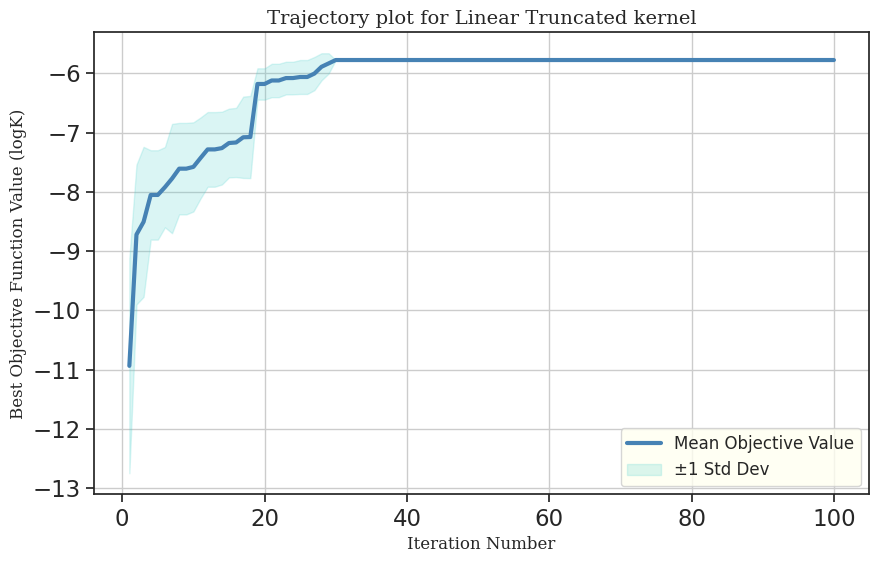

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_one_optimization(nb_iterations, init_sol_ids, verbose=False):
    #Run Bayesian Optimisation
    acquired_set = run_Bayesian_optimization(nb_iterations, init_sol_ids, verbose=verbose)
    #extract (y_train)
    y_train = build_y_train(acquired_set).numpy().ravel()
    best_so_far = [y_train[0]]
    for val in y_train[1:]:
        #maximum
        best_so_far.append(max(best_so_far[-1], val))

    return best_so_far

def run_multiple_optimizations(num_runs, nb_iterations, nb_SOLs, nb_solvent, initialization='random'):
    #decide initialisation
    all_runs_best = []

    for run_i in range(num_runs):
        if initialization == 'fixed':
            init_sol_ids = np.array(range(0, nb_solvent))
        else:
            #random
            init_sol_ids = np.random.randint(0, nb_SOLs, size=nb_solvent)

        best_so_far = run_one_optimization(nb_iterations, init_sol_ids, verbose=False)

        # Ensure we have nb_iterations values
        # If run_Bayesian_optimization stops early, pad with the last value
        if len(best_so_far) < nb_iterations:
            last_val = best_so_far[-1]
            best_so_far.extend([last_val]*(nb_iterations - len(best_so_far)))

        all_runs_best.append(best_so_far[:nb_iterations])

    #convert into numpy array
    all_runs_best = np.array(all_runs_best)
    return all_runs_best

def plot_mean_trajectory(all_runs_best):
    #mean and std
    mean_values = np.mean(all_runs_best, axis=0)
    std_values = np.std(all_runs_best, axis=0)

    nb_iterations = all_runs_best.shape[1]
    iterations = np.arange(1, nb_iterations + 1)


    plt.figure(figsize=(10, 6))
    plt.plot(iterations, mean_values, label='Mean Objective Value', color='steelblue')
    plt.fill_between(iterations, mean_values - std_values, mean_values + std_values,
                     color='mediumturquoise', alpha=0.2, label='±1 Std Dev')
    plt.xlabel("Iteration Number", fontsize=12, fontfamily='serif')
    plt.ylabel("Best Objective Function Value (logK)", fontsize=12, fontfamily='serif')
    plt.title("Trajectory plot for Linear Truncated kernel", fontsize=14, fontfamily='serif')
    plt.grid(True)
    plt.legend(fontsize=12, facecolor='ivory', loc='lower right')
    plt.show()

#run here
num_runs = 10
nb_iterations = 100
all_runs_best = run_multiple_optimizations(num_runs, nb_iterations, nb_SOLs, nb_solvent, initialization='random')
start_time    = time.time()
plot_mean_trajectory(all_runs_best)
